In [1]:
#do what the keras people suggest

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
plt.style.use('demo_style.mplstyle')

#tf.keras.backend.clear_session()  # For easy reset of notebook state.


In [2]:
#get job info

import os

os.environ["SLURM_JOB_ID"]

'739373'

In [3]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14462326903646457656
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10180760685754431398
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15782395904
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 7803349394554644411
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:89:00.0, compute capability: 7.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16304318648243863049
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
q003_data = np.load('/global/cscratch1/sd/stephey/march2020_data/Output/q003_data.npy')
q003_max = np.load('/global/cscratch1/sd/stephey/march2020_data/Output/q003_max.npy')
q003_norm = np.load('/global/cscratch1/sd/stephey/march2020_data/Output/q003_norm.npy')

q103_data = np.load('/global/cscratch1/sd/stephey/march2020_data/Output2/q103_data.npy') 
q103_max = np.load('/global/cscratch1/sd/stephey/march2020_data/Output2/q103_max.npy')
q103_norm = np.load('/global/cscratch1/sd/stephey/march2020_data/Output2/q103_norm.npy')

In [5]:
#downsample for now

n=5 #

print(q003_data.shape)
print(q103_data.shape)

#use the normalized data!

q003_data = q003_data[0::n,:,:]
q103_data = q103_data[0::n,:,:]

print(q003_data.shape)
print(q103_data.shape)

(3151, 625, 512)
(6636, 625, 512)
(631, 625, 512)
(1328, 625, 512)


In [6]:
#cut to make square for later autoencoder friendly size

q003_data = q003_data[:,0:512,:]

q103_data = q103_data[:,0:512,:]


In [7]:
#we shuffle in the training so it's ok
qall_data = np.concatenate((q003_data, q103_data), axis=0)

print(qall_data.shape)

#shuffle by default
x_train, x_test = train_test_split(qall_data, random_state=42) 
print(x_train.shape)
print(x_test.shape)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)
print(x_test.shape)

##can we memorize a single image
#x_train = x_train[0:1,:]
##train and test on the same image?
#x_test = x_train


(1959, 512, 512)
(1469, 512, 512)
(490, 512, 512)
(1469, 512, 512, 1)
(490, 512, 512, 1)


In [8]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

#input_dim = x_train.shape[1] #625*512, flattened is 320k
#don't flatten!

inputs = layers.Input(shape=(512, 512, 1))  # adapt this if using `channels_first` image data format

## Latent space
latent_dim = 8

inputs = Input(shape=(512, 512, 1), name="inputs")
x = inputs

#encoder
x = Conv2D(32, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Conv2D(32, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Conv2D(16, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Conv2D(16, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Conv2D(8, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Conv2D(8, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Conv2D(8, (7, 7), padding="same", strides=(2, 2))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#x = MaxPool2D((2, 2))(x)

x = Flatten()(x)
units = x.shape[1]
x = Dense(latent_dim, name="latent")(x)
x = Dense(units)(x)
x = LeakyReLU(alpha=0.2)(x)

#encoded data

#decoder

#first reshape to undo flatten
x = Reshape((4,4,8))(x)

x = Conv2DTranspose(8, (7, 7), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(8, (7, 7), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(4, (7, 7), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(4, (7, 7), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(2, (7, 7), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(2, (7, 7), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(1, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("sigmoid", name="outputs")(x)

outputs = x

    
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(1e-4), loss='binary_crossentropy')
autoencoder.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      50208     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0     

In [9]:
#encoder model


encoder = keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('latent').output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      50208     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0   

In [ ]:

# This function keeps the learning rate at 0.001 for the first ten epochs
# and decreases it exponentially after that.

#aim for 1e-8 at final epoch
#start with 1e-3 
#every x epochs half the learning rate

numepochs= 30 

def scheduler(epoch):
    if epoch < 30:
        print("learning rate: {}".format(0.001))
        return 0.001
    else:
        print("learning rate: {}".format(0.001 * tf.math.exp(0.05 * (20 - epoch))))
        return 0.001 * tf.math.exp(0.05 * (20 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)        

history = autoencoder.fit(x_train, x_train,
                epochs=numepochs,
                batch_size=64,
                validation_data=(x_test, x_test),
                shuffle=True, 
                verbose=1,
                callbacks=[callback])

print('\nhistory dict:', history.history)


#save our encoder AND our trained model!

esave = 'encoder_model_n' + str(n) + '.h5'
asave = 'autoencoder_model_n' + str(n) + '.h5'

encoder.save(esave)
autoencoder.save(asave)


Train on 1469 samples, validate on 490 samples
learning rate: 0.001
Epoch 1/30
1469/1469 [==============================] - 24s 16ms/sample - loss: 0.1926 - val_loss: 0.1910
learning rate: 0.001
Epoch 2/30
1469/1469 [==============================] - 12s 8ms/sample - loss: 0.1895 - val_loss: 0.1878
learning rate: 0.001
Epoch 3/30
1469/1469 [==============================] - 15s 10ms/sample - loss: 0.1865 - val_loss: 0.1847
learning rate: 0.001
Epoch 4/30
1469/1469 [==============================] - 6s 4ms/sample - loss: 0.1835 - val_loss: 0.1825
learning rate: 0.001
Epoch 5/30
1469/1469 [==============================] - 6s 4ms/sample - loss: 0.1806 - val_loss: 0.1801
learning rate: 0.001
Epoch 6/30
1469/1469 [==============================] - 6s 4ms/sample - loss: 0.1778 - val_loss: 0.1778
learning rate: 0.001
Epoch 7/30
1469/1469 [==============================] - 7s 5ms/sample - loss: 0.1749 - val_loss: 0.1744
learning rate: 0.001
Epoch 8/30
1469/1469 [==============================

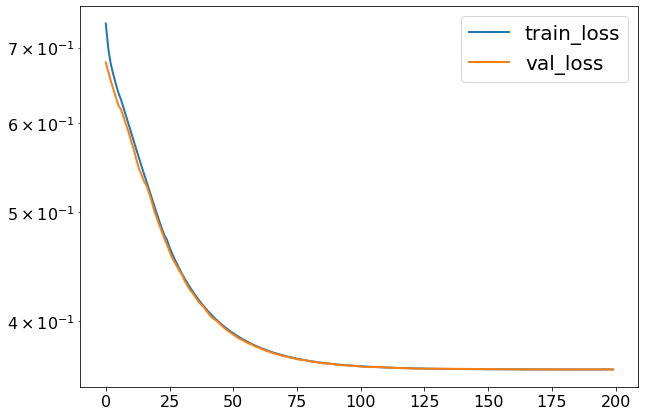

In [12]:
#plot the training loss and the validation loss

plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.yscale('log')
plt.legend()

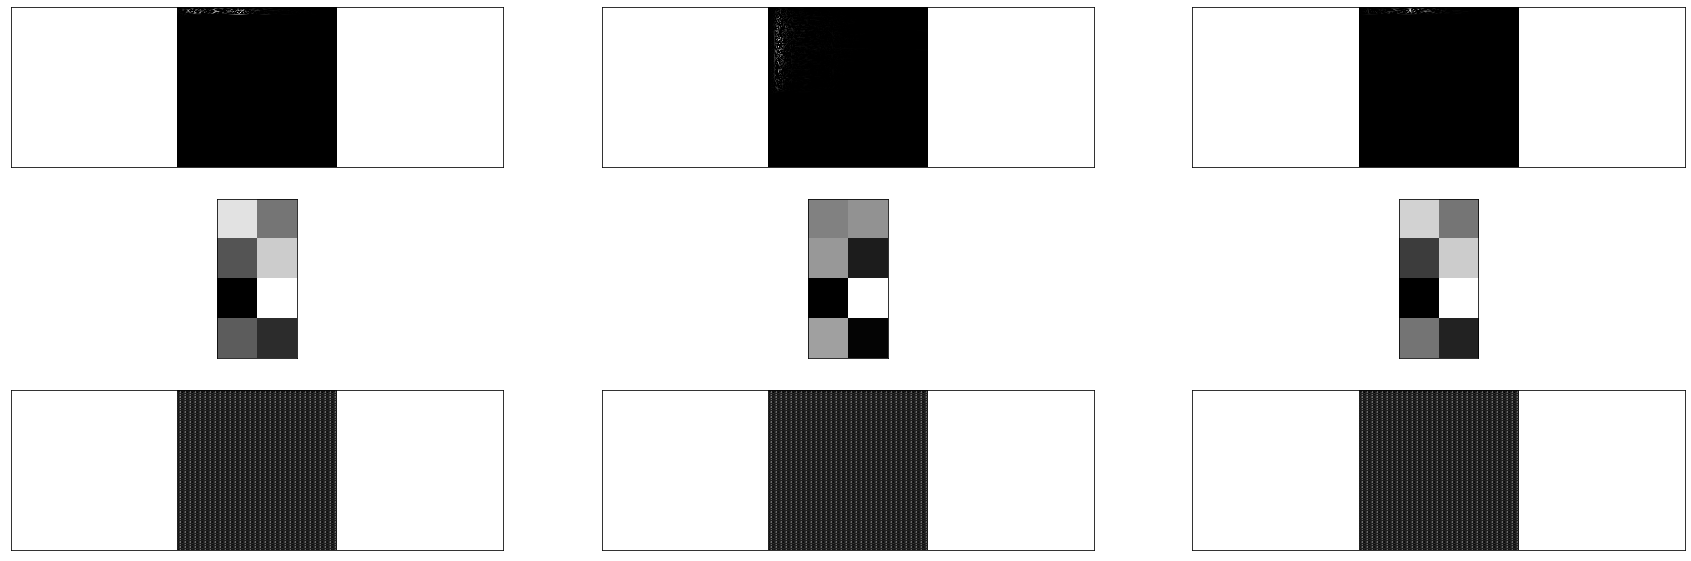

In [13]:
num_images = 3
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(30, 10))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(512, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis('equal')
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(4,2))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(512, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis('equal')
plt.show()


In [14]:
#now put all our data in the encoder why not


qall_reshape = np.expand_dims(qall_data, -1)
encoded_all = encoder.predict(qall_reshape)

print(encoded_all.shape)


(1959, 8)


In [ ]:

#Try pca on encoded images why not
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
#need to flatten i guess?
img_pca = pca.fit_transform(encoded_all)

#boundary 1
boundary1 = q003_data.shape[0]

color_key=['red','blue']
color_label=[]
for i in range(qall_data.shape[0]):
    if i < boundary1:
        color_label.append(color_key[0])
    else:
        color_label.append(color_key[1])
        
print(len(color_label))   
print(len(img_pca))

In [ ]:
#try making a nicer figure for maxim

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

msize = 16

#hack the legend together
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Quench 003',
                          markerfacecolor='red', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 103',
                          markerfacecolor='blue', markersize=8)]

# Create the figure and add our hacked legend
plt.figure(figsize=(10, 7))
for i in range(qall_data.shape[0]):
    plt.scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
plt.title('Case 1 PCA components of latent space')
plt.legend(handles=legend_elements)
plt.show()
plt.savefig("pca_norm.png")

In [ ]:
#make the same plot but show all quenches separately

msize = 8

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        axs[0].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[0].set_title('Quench 003')
    else:
        axs[1].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='PCA compononent 0', ylabel='PCA component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()